## Vehicle Classifier  (Car v/s Non-Car)


In [10]:
import cv2
import glob
import time
import pickle
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML

# classifier library
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [12]:
class ImageFeatureExtractor(object):
    '''
    Image feature extraction
    '''
    
    def __init__(self, params:dict):
        '''
         param: params - a dictionary of parameters with following keys: 
                        'car_images'      - vehicle images
                        'notcar_images'   - non vehicle images
                        'color_space'     - color space
                        'orient'          - hog orientation
                        'pix_per_cell'    - pixels per cell
                        'cell_per_block'  - cells per block
                        'hog_channel'     - hog channels
                        'spatial_size'    - bin spatial size
                        'hist_bins'       - histogram bins  
                        'spatial_feature' - extract bin spatial feature
                        'hist_feature'    - extract histogram features
                        'hog_feature'     - extract hog feature
                        'sample_size'     - training sample size
                        'image_size'      - size of the training image
        '''
        self.car_images      = params.get('car_images')
        self.notcar_images   = params.get('notcar_images')
        self.color_space     = params.get('color_space', 'RGB')
        self.orient          = params.get('orient', 9)
        self.pix_per_cell    = params.get('pix_per_cell', 8)
        self.cell_per_block  = params.get('cell_per_block', 2)
        self.hog_channels    = params.get('hog_channels', (0, 1, 2))
        self.spatial_size    = params.get('spatial_size', (16, 16))
        self.hist_bins       = params.get('hist_bins', 16)
        self.spatial_feature = params.get('spatial_feature', True)
        self.hist_feature    = params.get('hist_feature', True)
        self.hog_feature     = params.get('hog_feature', True)
        self.sample_size     = params.get('sample_size', None)
        self.image_size      = params.get('image_size', (64, 64))
        
    
    def getHogFeatures(self, image, orient, pix_per_cell, cell_per_block, visualise = False, feature_vector = True):
        '''
        Extract hog feature vector from image
        param: image - image object
        param: orient - hog orientations
        param: pix_per_cell - no of pixels in a cell
        param: cell_per_block - no of cell in a block
        param: visualise - hog image would be returned if set to True
        param: feature_vector - calculate hog feature vector
        return: hog feature vector
        '''
        if visualise == True:
            
            features, hog_image = hog(image, orientations = orient, 
                                      pixels_per_cell = (pix_per_cell, pix_per_cell),
                                      cells_per_block = (cell_per_block, cell_per_block),
                                      block_norm = 'L2-Hys', transform_sqrt = False, 
                                      visualise = visualise, feature_vector = feature_vector)
            
            return (features, hog_image)
        
        else:    
            
            features = hog(image, orientations = orient, 
                           pixels_per_cell = (pix_per_cell, pix_per_cell),
                           cells_per_block = (cell_per_block, cell_per_block),
                           block_norm = 'L2-Hys', transform_sqrt = False, 
                           visualise = visualise, feature_vector = feature_vector)
            
            return features

        
    def getBinSpatial(self, image, size=(32, 32)):
        '''
        Bin spatial of color space across channels
        param: image - image object
        param: size - resized vector of the image
        return: stacked channels of bins
        '''
        channel1 = cv2.resize(image[:,:,0], size).ravel()
        channel2 = cv2.resize(image[:,:,1], size).ravel()
        channel3 = cv2.resize(image[:,:,2], size).ravel()
        
        return np.hstack((channel1, channel2, channel3))
        
        
    def getColorHistogram(self, image, nbins=32):
        '''
        Get histogram of color channels
        param: image - image object
        param: nbins - no of bins in the histogram
        return: stacked color channel histograms
        '''
       
        channel1_hist = np.histogram(image[:,:,0], bins=nbins)
        channel2_hist = np.histogram(image[:,:,1], bins=nbins)
        channel3_hist = np.histogram(image[:,:,2], bins=nbins)
        
        # concatenate all channels
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        
        return hist_features


    def transformColorSpace(self, image, image_space = 'BGR', color_space = 'RGB'):
        '''
        Transform image to given color space
        param: image - image object
        param: image_space - image color space in RGB or BGR
        param: color_space - transformed color space
        return: image object in transformed color space
        '''
        
        if image_space not in ('RGB', 'BGR'):
            print('Unrecogrnized image space for color transformation. {}'.format(image_space))
            return None

        trans_image = image
        
        if image_space == 'BGR':
            # convert to RGB space
            b,g,r = cv2.split(image)
            trans_image = cv2.merge([r,g,b])

        if color_space != 'RGB':
            if color_space == 'HSV':
                trans_image = cv2.cvtColor(trans_image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                trans_image = cv2.cvtColor(trans_image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                trans_image = cv2.cvtColor(trans_image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                trans_image = cv2.cvtColor(trans_image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                trans_image = cv2.cvtColor(trans_image, cv2.COLOR_RGB2YCrCb)
            else:
                print('Unrecognized color space transformation. {}'.format(color_space))

        return trans_image

    
    def extractImageFeatures(self, image, image_space = 'BGR'):
        '''
        Extract image feature vectors
        param: image_space - color space of the image
        return: feature vector array for the image
        '''
        color_space     = self.color_space
        spatial_size    = self.spatial_size
        hist_bins       = self.hist_bins
        orient          = self.orient
        pix_per_cell    = self.pix_per_cell
        cell_per_block  = self.cell_per_block
        hog_channels    = self.hog_channels
        spatial_feature = self.spatial_feature
        hist_feature    = self.hist_feature
        hog_feature     = self.hog_feature
        
        features = []
        
        trans_image = self.transformColorSpace(image, image_space = image_space, color_space = color_space)

        # extract bin spatial feature vector
        if spatial_feature == True:
            feature = self.getBinSpatial(trans_image, size = spatial_size)
            features.append(feature)
        
        # extract color histogram feature vector
        if hist_feature == True:
            feature = self.getColorHistogram(trans_image, nbins = hist_bins)
            features.append(feature)
            
        # extract hog feature
        if hog_feature == True:
            hog_features = []
            for channel in hog_channels:
                feature = self.getHogFeatures(trans_image[:,:, channel], 
                                              orient = orient, pix_per_cell = pix_per_cell, 
                                              cell_per_block = cell_per_block, 
                                              visualise = False, feature_vector = True)
                hog_features.append(feature)
            
            hog_features = np.ravel(hog_features)
            features.append(hog_features)
               
        # stack all feature vectors together
        features = np.concatenate(features)
    
        return features
    
    
    def extractFeatureVectors(self):
        '''
        Build training data
        return: a tuple of car and not-car feature vectors
        '''
        # Read in cars and notcars
        cars = self.car_images
        notcars = self.notcar_images
        
        if self.sample_size != None:
            cars = cars[0:self.sample_size]
            notcars = notcars[0:self.sample_size]

        image_space = 'BGR'
        car_features = []
        notcar_features = []
        
        # Extract feature vector for car images
        for car_image in cars:
            image = cv2.imread(car_image)
            feature = self.extractImageFeatures(image, image_space = image_space)
            car_features.append(feature)
            
        # Extract feature vector for non-car images
        for notcar_image in notcars:
            image = cv2.imread(notcar_image)
            feature = self.extractImageFeatures(image, image_space = image_space)
            notcar_features.append(feature)
                
        return (car_features, notcar_features)

In [17]:
class ImageClassifier(object):
    '''
    Image classifier to classify car and not car images
    '''
    
    def __init__(self, feature_extractor: ImageFeatureExtractor, test_size = 0.2):
        '''
        Initialize image classifier
        param: feature_extractor: feature extractor object of type ImageFeatureExtractor to extract training data
        '''
        self.feature_extractor = feature_extractor
        self.test_size = 0.2
        self.model = None
        self.scaler = None
        
        
    def fit(self, x, y, verbose = 2):
        '''
        Fit a svm classifier through grid search
        '''
        
        print('Training SVM classifier...')
        
        start = time.time()
        
        # find the best fit 
        #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
        parameters = {'C':[1, 10]}
        svc = svm.SVC()
        
        clf = GridSearchCV(svc, parameters, verbose = verbose)
        model = clf.fit(x, y)
        
        stop = time.time()
        
        print('Trained SVM. Time elapsed: {} seconds. Best Parameters: {}'.
              format(round(stop - start, 2), clf.best_params_))
        
        return model
        
        
    def train(self, verbose = 2):
        '''
        Train classifier
        '''

        print('Extracting feature vectors for car and non-car images')
        
        car_features, notcar_features = self.feature_extractor.extractFeatureVectors()
        
        print('Extracted training data. Car images: {}, Non-Car Images: {}, Feature Vectors: {}'.
              format(len(car_features), len(notcar_features), len(car_features[0])))
        
        x = np.vstack((car_features, notcar_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        randomizer = np.random.randint(0, 100)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = self.test_size, random_state= randomizer)

        # scale training data
        self.scaler = StandardScaler().fit(x_train)
        x_train = self.scaler.transform(x_train)
        
        # scale test data by training data scaler
        x_test = self.scaler.transform(x_test)
        
        self.model = self.fit(x_train, y_train, verbose = verbose)
        
        train_accuracy = self.model.score(x_train, y_train)
        test_accuracy = self.model.score(x_test, y_test)
        
        # print classifier accuracy
        print('Training accuracy: {}'.format(round(train_accuracy, 4)))
        print('Test accuracy: {}'.format(round(test_accuracy, 4)))
        
        
    def classify(self, image, image_space = 'BGR'):
        '''
        Classify if the image is of a vehicle or not
        param: image - image object to be classified
        param: image_space - color space of the image either in 'BGR' or 'RGB'
        return 1 if image is of a vehicle, 0 otherwise
        '''
        
        # resize image of the trained image size
        image = cv2.resize(image, self.feature_extractor.image_size)
        
        # extract features and scale it
        features = self.feature_extractor.extractImageFeatures(image, image_space = image_space)
        features = self.scaler.transform(np.array(features).reshape(1, -1))
        
        # predict
        car = self.model.predict(features)
        
        return car

In [18]:
def getVehicleImages():
    images = []
    gti_far     = glob.glob('./data/vehicles/GTI_Far/*.png')
    gti_left    = glob.glob('./data/vehicles/GTI_Left/*.png')
    gti_middle  = glob.glob('./data/vehicles/GTI_MiddleClose/*.png')
    gti_right   = glob.glob('./data/vehicles/GTI_Right/*.png')
    
    images.extend(gti_far)
    images.extend(gti_left)
    images.extend(gti_middle)
    images.extend(gti_right)
    
    print('Vehicle images: {}'.format(len(images)))
    
    return images

def getNonVehicleImages():
    
    images = []
    extras = glob.glob('./data/non-vehicles/Extras/*.png')
    gti    = glob.glob('./data/non-vehicles/GTI/*.png')
    
    images.extend(extras)
    images.extend(gti)
    
    print('Non-Vehicle images: {}'.format(len(images)))
    
    return images


def getTrainingParameters():
    train_params = {}
    
    train_params['car_images']       = getVehicleImages()
    train_params['notcar_images']    = getNonVehicleImages()
    train_params['color_space']     = 'RGB'
    #train_params['color_space']     = 'HLS'
    train_params['orient']          = 9
    train_params['pix_per_cell']    = 8
    train_params['cell_per_block']  = 2
    train_params['hog_channels']    = (0, 1, 2)
    train_params['spatial_size']    = (16, 16)
    train_params['hist_bins']       = 16
    train_params['spatial_feature'] = True
    train_params['hist_feature']    = True
    train_params['hog_feature']     = True
    train_params['sample_size']     = None
    train_params['image_size']      = (64, 64)

    return train_params

In [23]:
# get training parameters
train_params = getTrainingParameters()
feature_extractor = ImageFeatureExtractor(params = train_params)

Vehicle images: 2826
Non-Vehicle images: 8968


In [26]:
def showHogFeatures(feature_extractor, image_name, text):
    '''
    Extract and show hog feature image
    '''
    image = cv2.imread(image_name)
    feature, feature_image = feature_extractor.getHogFeatures(image[:,:, 2], orient = feature_extractor.orient, 
                                                 pix_per_cell = feature_extractor.pix_per_cell, 
                                                 cell_per_block = feature_extractor.cell_per_block, 
                                                 visualise = True, feature_vector = True)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 15))
    f.tight_layout()
    
    b,g,r = cv2.split(image)
    image = cv2.merge([r, g, b])
    
    ax1.imshow(image)
    ax1.set_title(text, fontsize=40)
            
    ax2.imshow(feature_image, cmap = 'gray')
    ax2.set_title('HOG Feature', fontsize=40)
    

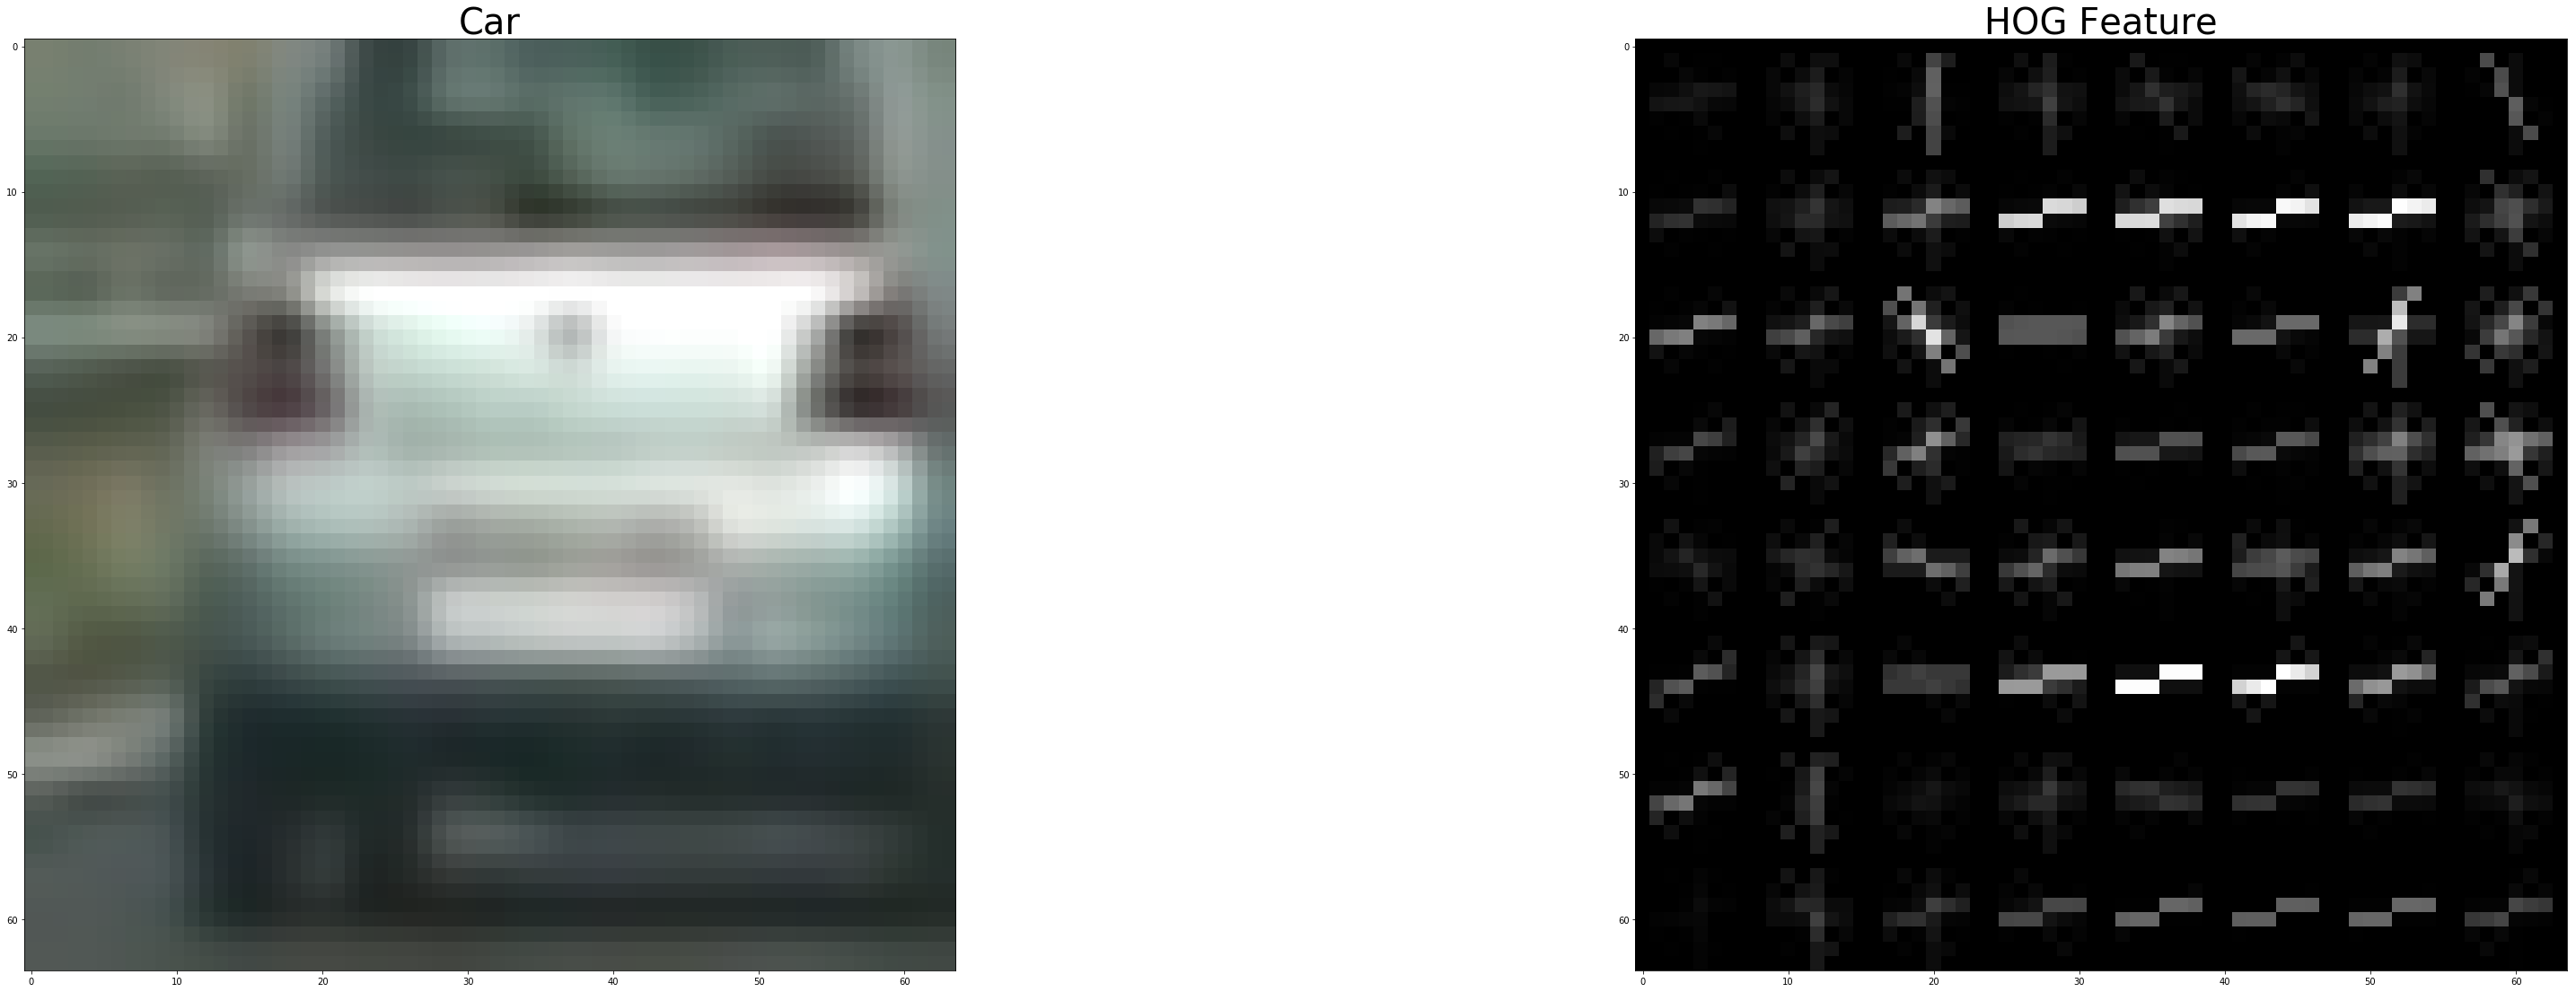

In [28]:
# show car sample image and corresponding HOG feature
car_sample = train_params['car_images'][100]

showHogFeatures(feature_extractor, car_sample, 'Car')


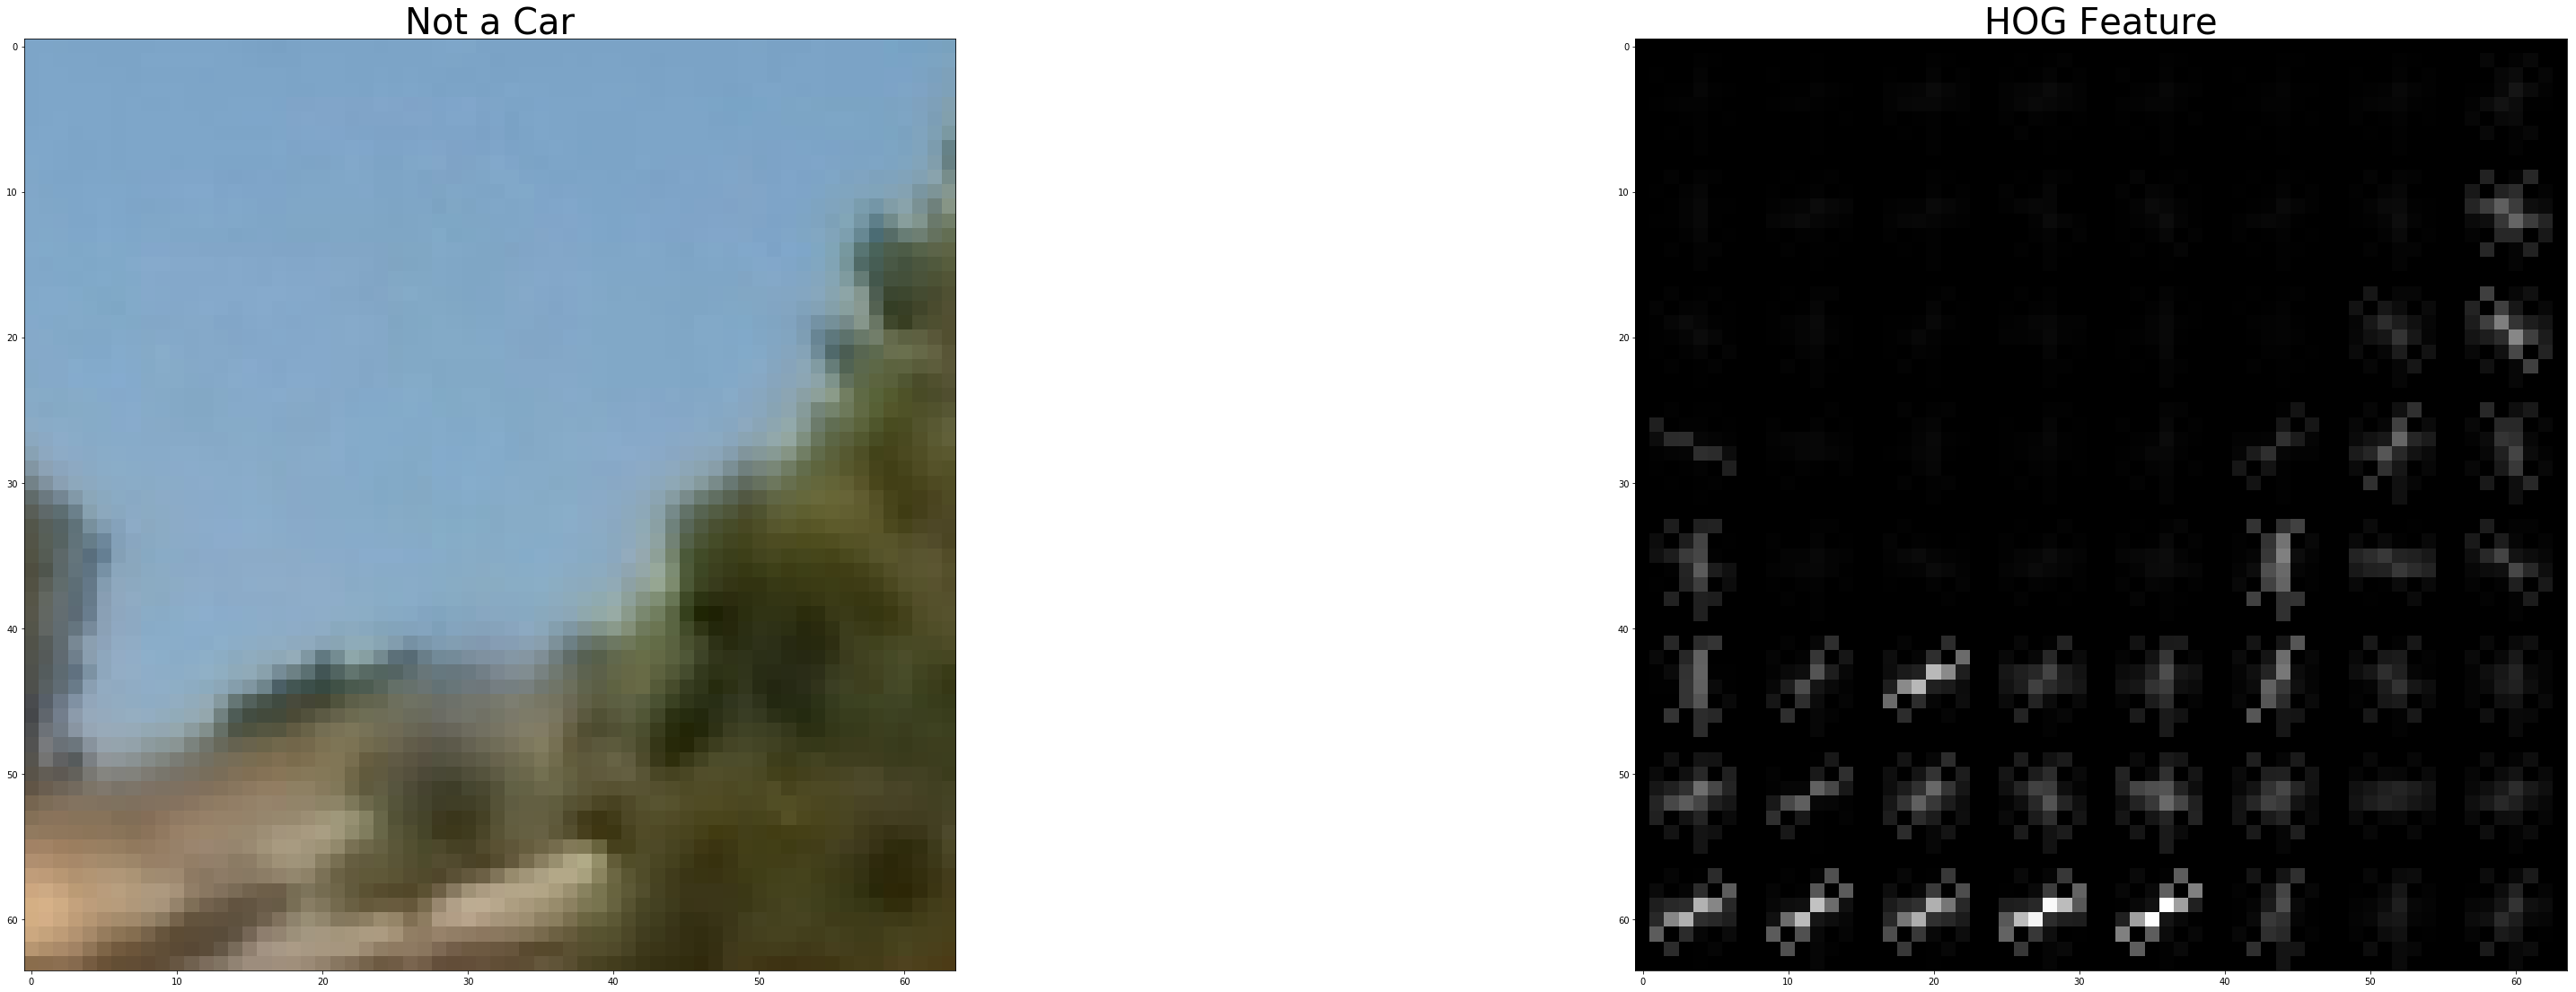

In [34]:
# show non-car sample image and corresponding HOG feature
noncar_sample = train_params['notcar_images'][662]
showHogFeatures(feature_extractor, noncar_sample, 'Not a Car')


In [20]:
# train classifier
classifier = ImageClassifier(feature_extractor)

classifier.train()

Extracting feature vectors for car and non-car images
Extracted training data. Car images: 2826, Non-Car Images: 8968, Feature Vectors: 6108
Training SVM classifier...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] C=1 .............................................................
[CV] .............................................. C=1, total= 1.1min
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] .............................................. C=1, total= 1.1min
[CV] C=1 .............................................................
[CV] .............................................. C=1, total= 1.1min
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  48.7s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  48.2s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  49.7s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.3min finished


Trained SVM. Time elapsed: 622.22 seconds. Best Parameters: {'C': 10}
Training accuracy: 0.9997
Test accuracy: 0.9903


In [21]:
# save classifier
model_file = 'model.p'
pickle.dump(classifier, open(model_file, "wb"))

print('Saved model to \'{}'.format(model_file))

Saved model to 'model.p
